# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from PIL import Image as pil_image

import skimage
import lime_image

from skimage.segmentation import mark_boundaries

## Looking at the data

In [4]:
path = untar_data(URLs.PETS); path

PosixPath('/home/vasudha12570/.fastai/data/oxford-iiit-pet')

In [5]:
path_anno = path/'annotations'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/vasudha12570/.fastai/data/oxford-iiit-pet/images/keeshond_148.jpg'),
 PosixPath('/home/vasudha12570/.fastai/data/oxford-iiit-pet/images/shiba_inu_129.jpg'),
 PosixPath('/home/vasudha12570/.fastai/data/oxford-iiit-pet/images/scottish_terrier_143.jpg'),
 PosixPath('/home/vasudha12570/.fastai/data/oxford-iiit-pet/images/basset_hound_118.jpg'),
 PosixPath('/home/vasudha12570/.fastai/data/oxford-iiit-pet/images/shiba_inu_185.jpg')]

In [7]:
np.random.seed(2)
pat = re.compile(r'/([^/]+)_\d+.jpg$')

In [8]:
bs = 64
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

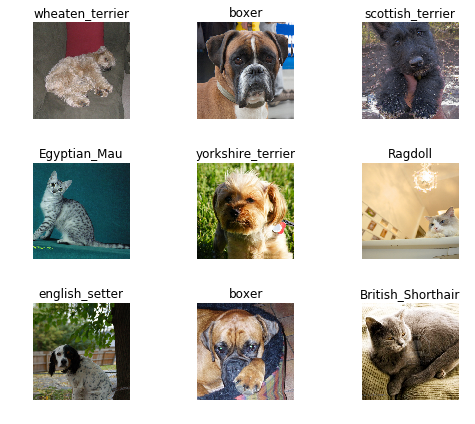

In [9]:
data.show_batch(rows=3, figsize=(7,6))

In [10]:
print(data.classes)
len(data.classes),data.c

['keeshond', 'shiba_inu', 'scottish_terrier', 'newfoundland', 'miniature_pinscher', 'saint_bernard', 'basset_hound', 'Egyptian_Mau', 'Abyssinian', 'american_pit_bull_terrier', 'japanese_chin', 'Persian', 'american_bulldog', 'pomeranian', 'pug', 'german_shorthaired', 'beagle', 'leonberger', 'Maine_Coon', 'staffordshire_bull_terrier', 'Russian_Blue', 'Ragdoll', 'Birman', 'Bengal', 'British_Shorthair', 'Bombay', 'chihuahua', 'great_pyrenees', 'wheaten_terrier', 'samoyed', 'Siamese', 'english_cocker_spaniel', 'boxer', 'Sphynx', 'havanese', 'yorkshire_terrier', 'english_setter']


(37, 37)

## Training: resnet50

In [11]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [12]:
learn.fit_one_cycle(7)

Total time: 23:26
epoch  train_loss  valid_loss  error_rate
1      0.543939    0.265209    0.087280    (03:49)
2      0.365446    0.198074    0.065629    (03:15)
3      0.312436    0.234545    0.074425    (03:15)
4      0.234909    0.216487    0.066306    (03:16)
5      0.167689    0.223236    0.064953    (03:16)
6      0.109064    0.174646    0.055480    (03:16)
7      0.097582    0.177076    0.055480    (03:16)



In [12]:
#learn.save('stage-1-res50-size299')
learn.load('stage-1-res50-size299')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (5912 items)
[Category keeshond, Category shiba_inu, Category scottish_terrier, Category newfoundland, Category miniature_pinscher]...
Path: /home/vasudha12570/.fastai/data/oxford-iiit-pet/images
x: ImageItemList (5912 items)
[Image (3, 349, 500), Image (3, 333, 500), Image (3, 442, 463), Image (3, 333, 500), Image (3, 375, 500)]...
Path: /home/vasudha12570/.fastai/data/oxford-iiit-pet/images;
Valid: LabelList
y: CategoryList (1478 items)
[Category Birman, Category german_shorthaired, Category keeshond, Category pug, Category Abyssinian]...
Path: /home/vasudha12570/.fastai/data/oxford-iiit-pet/images
x: ImageItemList (1478 items)
[Image (3, 500, 500), Image (3, 500, 333), Image (3, 500, 375), Image (3, 300, 223), Image (3, 363, 600)]...
Path: /home/vasudha12570/.fastai/data/oxford-iiit-pet/images;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=F

## Into the Model

In [13]:
tmp_img = open_image('pet_imgs/ragdoll.jpg')#'pet_imgs/shiba-inus.jpg')
pred_class, pred_idx, outputs = learn.predict(tmp_img)
print (pred_class)

Ragdoll


In [14]:
#from PIL import Image as pil_image
#import scikit_image as skimage
#import lime_image
#from skimage.segmentation import mark_boundaries
from IPython.display import HTML, display
import random

In [15]:
def predict_fn(img):
    x = img.convert('RGB')
    test_img = Image(pil2tensor(x, np.float32).div_(255))
    pred_class, pred_idx, outputs = learn.predict(test_img)
    print (pred_class)
    return outputs.numpy()#my_softmax(preds)

def softmax(x):
    tmp = np.zeros_like(x)
    """Compute softmax values for each sets of scores in x."""
    for i in range(x.shape[0]):
        s = np.exp(x[i, :])/np.sum(np.exp(x[i, :]))
        tmp[i, :] = s
    return tmp # only difference

def batch_predict(images):
    for i, img in enumerate(images):
        output = predict_fn(img)
        print (output)
        if i == 0:
            preds = output
        else:
            preds = np.concatenate((preds, output), axis=0 )
    return softmax(preds.reshape(-1, len(pet_classes)))

In [28]:
#Plot images in a HTML table
def make_table(imgs_list):
    html_string = '<tr>'
    for index, file in enumerate(imgs_list):
        counter = random.randint(0,2e9) #hack to get jupyter to refresh the image
        class_name = file.split('_', 1)[1].split('.')[0]
        if(index % 4 == 0):
            html_string = html_string + f"""</tr><td>
             <p style="text-align:center"> {class_name} </p>
             <img src='{file}?{counter}'>
             </td>"""
        else:
            html_string = html_string + f"""<td>
             <p style="text-align:center"> {class_name} </p>
             <img src='{file}?{counter}'>
             </td>"""
    html_string = "<table>" + html_string + "</tr> </table>"
    display( HTML(html_string) )

def empty_folder(path):
    for f in os.listdir(path):
        os.remove(f'{path}/{f}')

def make_explanation(nn_explainer, classes, n_features):
    explained_imgs = []
    empty_folder('explanations')
    for index, i in enumerate(nn_explainer.top_labels):
        counter = random.randint(0,2e9)
        explain_class = classes[i]
        temp, mask = nn_explainer.get_image_and_mask(i, positive_only=False, num_features=n_features, hide_rest=False)
        save_path = f'explanations/jusitify_{explain_class}_{counter}.jpg'
        plt.imsave(save_path, mark_boundaries(temp, mask))
        explained_imgs.append(save_path)
    return explained_imgs

def show_explanation(nn_explainer, classes, n_features):
    imgs_list = make_explanation(nn_explainer, classes, n_features)
    make_table(imgs_list)

In [34]:
def show_explanation(justifier, classes, n_features):
    fig, axs = plt.subplots(2,4, figsize=(20, 10))
    #fig.subplots_adjust(hspace = .001, wspace=.001)
    axs = axs.ravel()

    for i in range(8):
        temp, mask = justifier.get_image_and_mask(justifier.top_labels[i], positive_only=False, num_features=n_features, hide_rest=False)
        img = mark_boundaries(temp, mask)
        axs[i].imshow(img)
        axs[i].set_title(pet_classes[justifier.top_labels[i]], size=20)
    plt.tight_layout()
    plt.show()

In [16]:
explainer = lime_image.LimeImageExplainer()

In [51]:
#tmp_img = pil_image.open('pet_imgs/shiba-inus.jpg')
#tmp_img = my_image.open('smile.png')
#tmp_img

In [17]:
pet_classes = data.classes

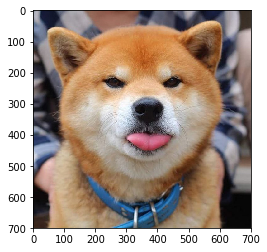

In [18]:
tmp_img = pil_image.open('pet_imgs/shiba-inu-dog.jpg')
plt.imshow(tmp_img)

In [19]:
%time justifier = explainer.explain_instance(tmp_img, classifier_fn=batch_predict, top_labels=8, num_samples=1000)

shiba_inu
[1.356653e-05 9.299087e-01 1.790852e-05 7.826823e-05 4.254982e-06 2.007716e-04 6.032586e-05 1.378153e-05 2.430874e-05
 7.905074e-06 2.721079e-05 6.988409e-04 2.431103e-05 5.941400e-02 1.324240e-06 1.261894e-05 5.901626e-04 2.004432e-05
 4.121737e-04 2.250503e-05 1.921464e-06 5.621069e-05 9.347249e-07 6.598946e-05 4.701052e-05 3.381530e-06 1.244086e-04
 5.730894e-03 4.079383e-04 1.770301e-03 1.919500e-07 2.069539e-05 8.428156e-05 3.561941e-06 1.113937e-04 1.778397e-05
 2.030209e-07]
CPU times: user 2min 39s, sys: 8.77 s, total: 2min 48s
Wall time: 1min 49s


In [20]:
justifier.top_labels

[1, 29, 13, 24, 26, 9, 16, 8]

In [21]:
[pet_classes[label] for label in justifier.top_labels]

['shiba_inu',
 'samoyed',
 'pomeranian',
 'British_Shorthair',
 'chihuahua',
 'american_pit_bull_terrier',
 'beagle',
 'Abyssinian']

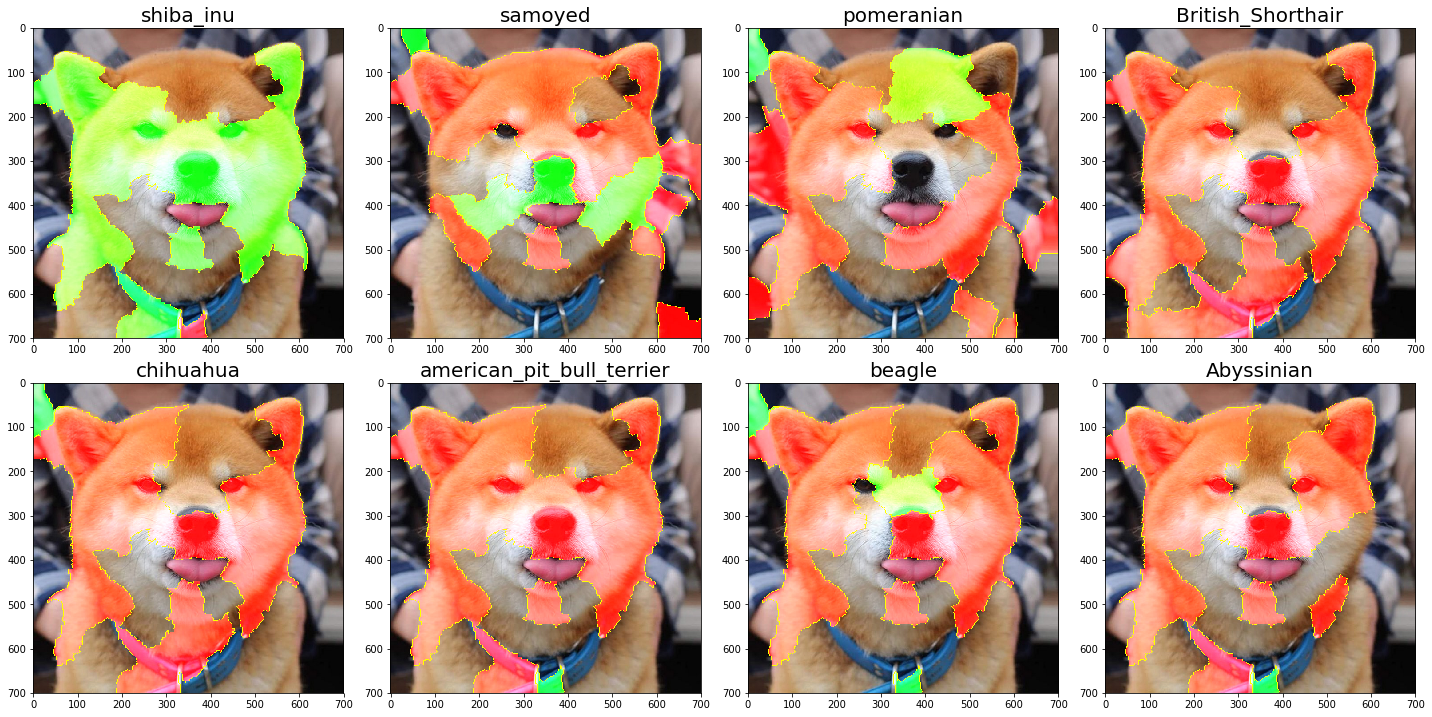

In [22]:
fig, axs = plt.subplots(2,4, figsize=(20, 10))
#fig.subplots_adjust(hspace = .001, wspace=.001)

axs = axs.ravel()

for i in range(8):
    temp, mask = justifier.get_image_and_mask(justifier.top_labels[i], positive_only=False, num_features=20, hide_rest=False)
    img = mark_boundaries(temp, mask)
    axs[i].imshow(img)
    axs[i].set_title(pet_classes[justifier.top_labels[i]], size=20)
plt.tight_layout()
plt.show()

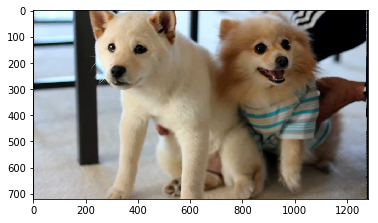

In [23]:
img = pil_image.open('pet_imgs/shiba_inu_pomerian.jpg')
plt.imshow(img)

In [24]:
%time justifier = explainer.explain_instance(img, classifier_fn=batch_predict, top_labels=8, num_samples=1000)

pomeranian
[2.492688e-04 1.270740e-03 1.702918e-05 7.853475e-06 3.166300e-05 1.530051e-04 6.865906e-06 2.051053e-06 4.233136e-07
 9.406539e-07 4.669400e-04 4.080105e-05 5.425229e-06 9.587258e-01 1.387467e-05 3.052272e-05 9.417382e-05 1.677265e-06
 1.097813e-06 1.764750e-07 3.687583e-07 1.204699e-03 2.924067e-04 7.575516e-06 4.470721e-07 6.738465e-06 9.710677e-04
 2.147786e-02 2.361493e-04 9.186495e-04 8.148538e-06 9.568559e-03 1.275704e-04 1.427250e-05 4.005563e-03 3.624155e-05
 3.367856e-06]
CPU times: user 4min 53s, sys: 14.2 s, total: 5min 8s
Wall time: 3min 18s


In [25]:
[data.classes[label] for label in justifier.top_labels]

['pomeranian',
 'shiba_inu',
 'samoyed',
 'chihuahua',
 'great_pyrenees',
 'english_cocker_spaniel',
 'american_pit_bull_terrier',
 'keeshond']

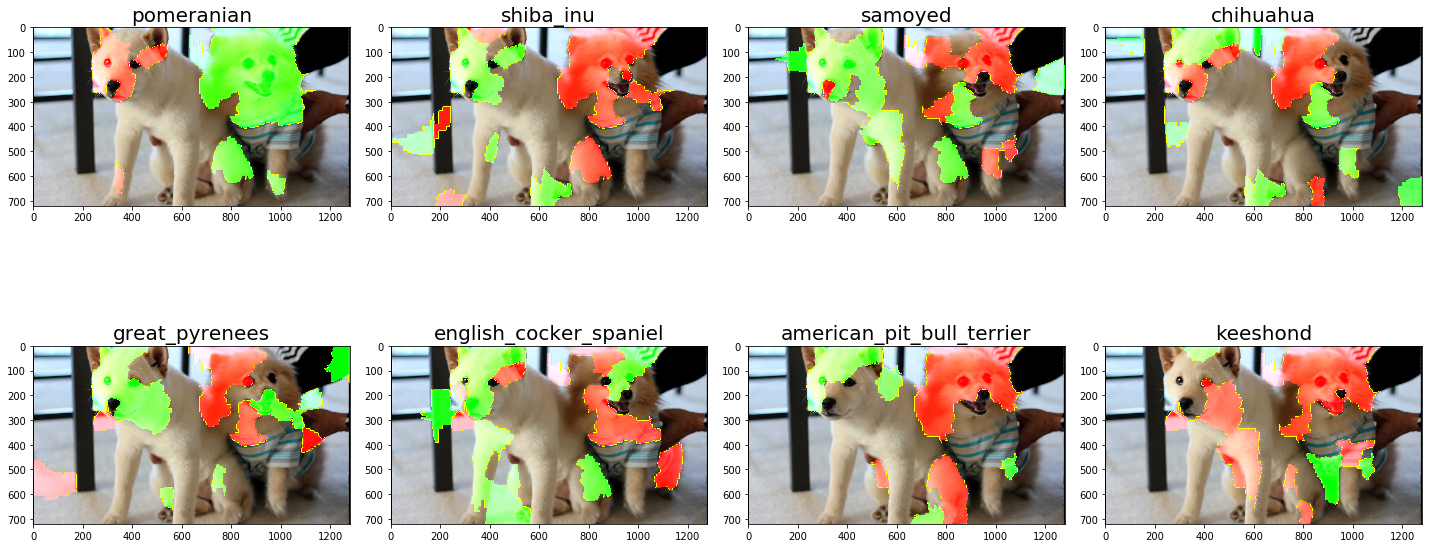

In [27]:
fig, axs = plt.subplots(2,4, figsize=(20, 10))
#fig.subplots_adjust(hspace = .001, wspace=.001)

axs = axs.ravel()

for i in range(8):
    temp, mask = justifier.get_image_and_mask(justifier.top_labels[i], positive_only=False, num_features=20, hide_rest=False)
    img = mark_boundaries(temp, mask)
    axs[i].imshow(img)
    axs[i].set_title(pet_classes[justifier.top_labels[i]], size=20)
plt.tight_layout()
plt.show()

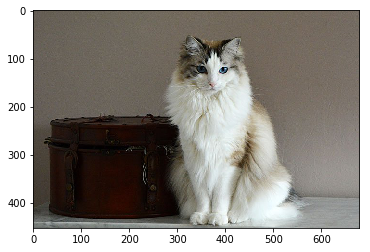

In [28]:
img = pil_image.open('pet_imgs/ragdoll.jpg')
plt.imshow(img)

In [29]:
%time justifier = explainer.explain_instance(img, classifier_fn=batch_predict, top_labels=8, num_samples=1000)

Ragdoll
[1.024142e-05 5.066429e-04 1.090284e-02 7.987291e-05 1.374871e-05 1.543880e-02 4.944121e-04 7.341444e-04 4.255416e-04
 4.825461e-05 5.643506e-03 3.611771e-03 1.240134e-04 1.468032e-04 6.686994e-06 2.542352e-05 7.919059e-04 4.525605e-04
 5.935722e-02 5.065009e-05 8.223665e-05 8.182930e-01 5.078624e-04 4.298310e-03 1.426722e-05 4.689306e-05 6.636130e-05
 1.822550e-03 4.822692e-02 9.732689e-04 7.945862e-05 2.231105e-04 1.454488e-03 6.508086e-05 2.464158e-02 1.317710e-04
 2.078543e-04]
CPU times: user 2min 7s, sys: 8.63 s, total: 2min 16s
Wall time: 1min 21s


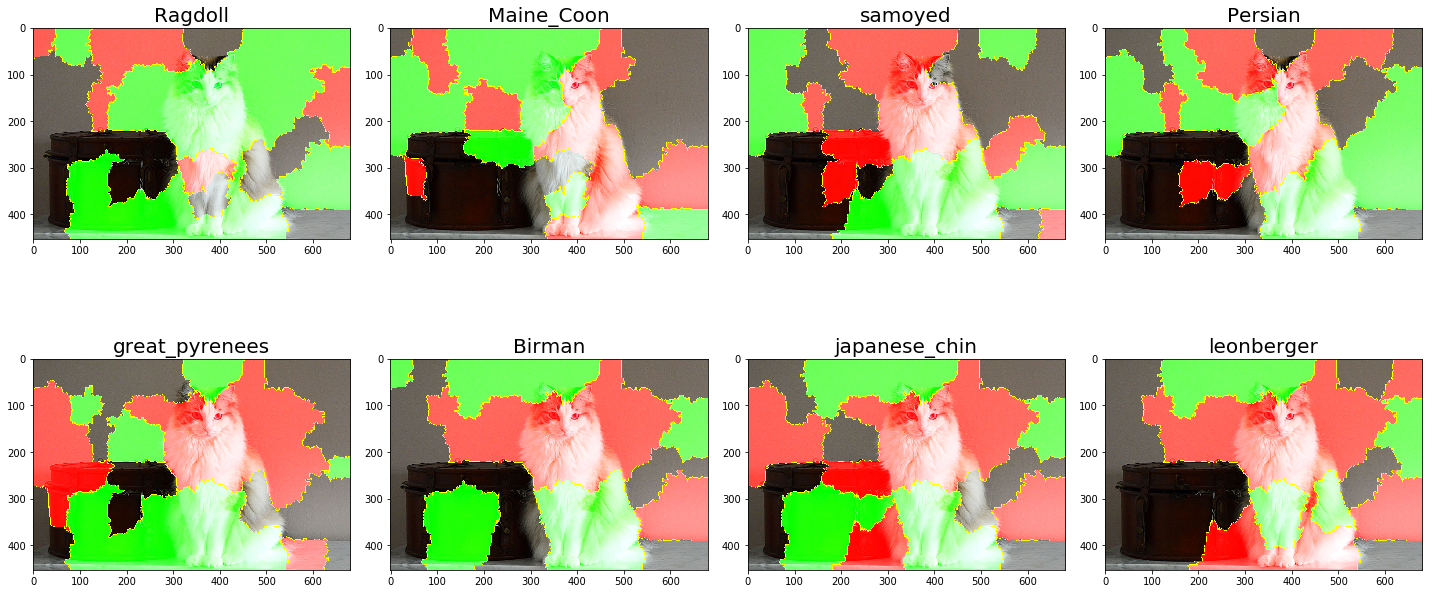

In [35]:
show_explanation(justifier, pet_classes, 20)

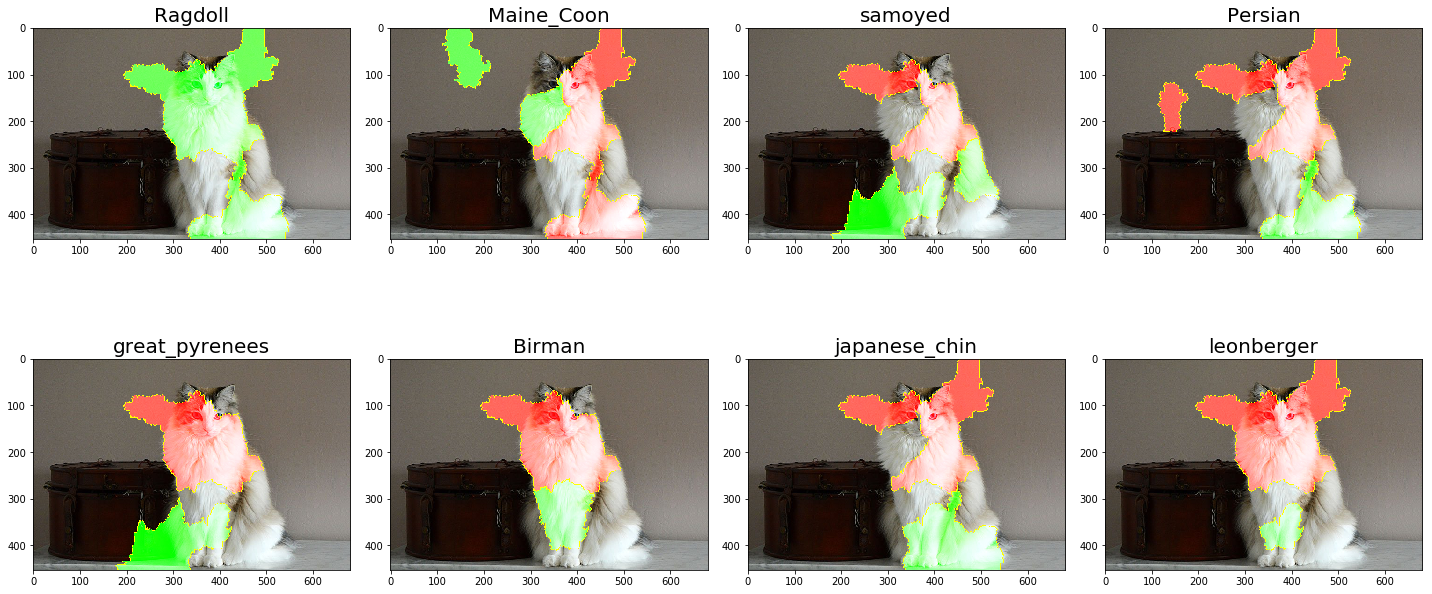

In [36]:
show_explanation(justifier, pet_classes, 5)

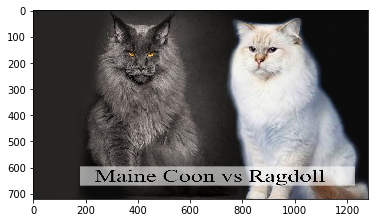

In [37]:
img = pil_image.open('pet_imgs/maine_coon_ragdoll.jpg')
plt.imshow(img)

In [38]:
%time justifier = explainer.explain_instance(img, classifier_fn=batch_predict, top_labels=8, num_samples=1000)

Persian
[2.731756e-06 2.019192e-08 9.667498e-07 1.312647e-06 4.708894e-09 1.621346e-09 3.464997e-08 7.681580e-07 3.926938e-09
 2.339567e-08 3.970207e-08 9.976110e-01 5.656682e-08 2.690057e-07 1.264801e-08 2.902960e-08 4.619046e-10 1.861508e-08
 1.176996e-03 6.086884e-09 8.774455e-07 1.157344e-05 3.865052e-06 4.450135e-07 1.175587e-03 8.345898e-07 4.028389e-10
 5.947553e-06 6.721593e-07 1.788257e-06 1.473763e-08 1.225865e-07 4.910607e-07 1.132211e-08 4.138416e-07 2.932404e-06
 3.389653e-08]
CPU times: user 4min 56s, sys: 14.2 s, total: 5min 10s
Wall time: 3min 21s


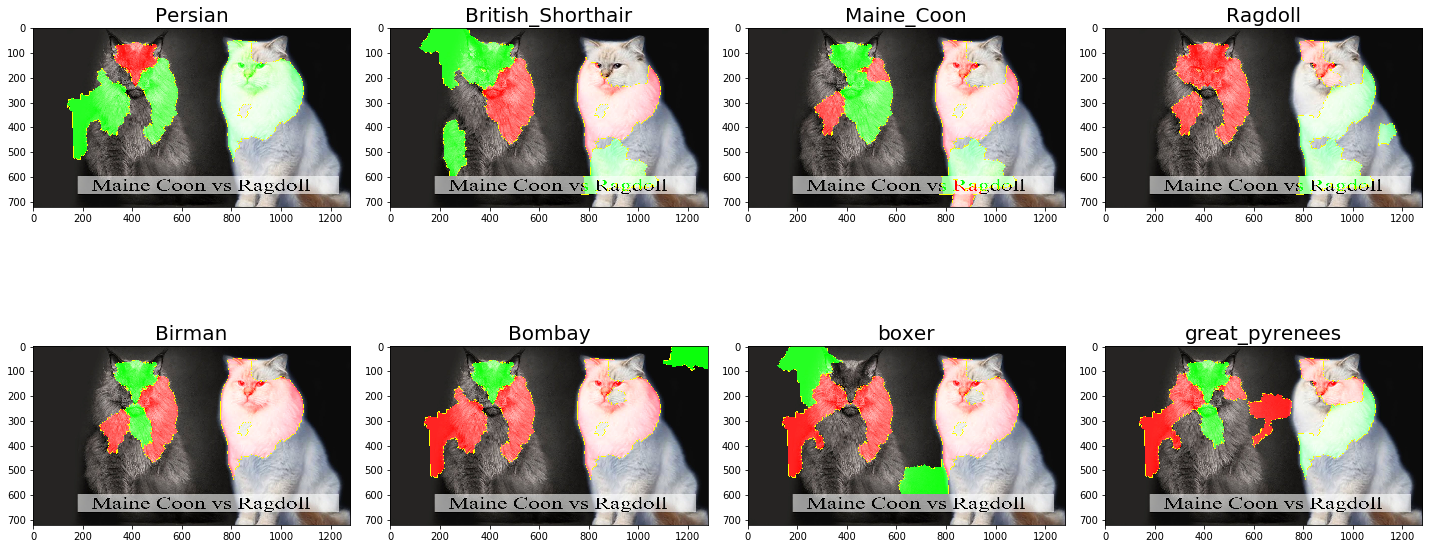

In [40]:
show_explanation(justifier, pet_classes, 10)

In [ ]:
#fin